### What is this notebook for? ###

The main purpose of this notebook is buiding Liquidity's probability model for the Otodom.pl, category "apartments for sell".

**Prerequisities:** "ml_dataset_otodompl.tsv". Can be obtained with `2.QualityDriversDataPrep-Otodom.ipynb`

**Output:**

* Stored model: `xgb_otodom_buy_02.pkl`
* Average price for city/rooms_num: `avg_city_price_otodom_buy_02.csv`
* Model columns name: `model_columns_xgb_otodom_buy_02.pkl`

In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib

from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
otodom_full = pd.read_csv("ml_dataset_otodompl.tsv", sep ="\t")

Select only listings in category 101, apartments for sell.

In [4]:
otodom_full = otodom_full[otodom_full['category_id'] == 101]

We will train our model on Jun-Nov data:

In [5]:
otodom_train_full = otodom_full[otodom_full['month'] !=12]

Data validation on December data:

In [6]:
otodom_test_full = otodom_full[otodom_full['month'] == 12]

In [7]:
def select_category(dataframe, category_id):
    dataframe = dataframe[dataframe['category_id'] == category_id]
    return dataframe

In [8]:
def filter_currency(dataframe, currency):
    dataframe = dataframe[dataframe['price[currency]'] == currency]
    return dataframe

In [9]:
def select_columns(dataframe, columns):
    dataframe = dataframe[columns]
    return dataframe

In [10]:
columns = ['ad_id', 
           'city_id', 
           'street_name', 
           'title', 
           'description', 
           'mysql_search_rooms_num', 
           'mysql_search_m', 
           'mysql_search_price', 
           'build_year', 
           'building_floors_num',  
           'building_material', 
           'building_ownership', 
           'building_type',
           'construction_status', 
           'equipment_types', 
           'extras_types', 
           'floor_no', 
           'heating', 
           'private_business', 
           'market', 
           'media_types',  
           'security_types', 
           'windows_type',
           'unique_senders',
           'n_images']

In [11]:
def filter_values(dataframe, col, values_list):
    dataframe = dataframe[dataframe[col].isin(values_list)]
    return dataframe

In [12]:
def remove_outliers(dataframe, col, lower_bound, upper_bound):
    dataframe = dataframe[(dataframe[col] >= lower_bound) & (dataframe[col] <= upper_bound)]
    return dataframe

In [13]:
def add_avg_price_city_ap_type(dataframe):
    city_n = pd.DataFrame({'city_n': dataframe.groupby(['city_id'])['ad_id'].nunique()}).reset_index()
    city_room_avg_price = pd.DataFrame({'avg_price': dataframe.groupby(['city_id', 'mysql_search_rooms_num'])['mysql_search_price'].mean()}).reset_index()
    dataframe = dataframe.merge(city_n, on='city_id', how='left')
    dataframe = dataframe.merge(city_room_avg_price, on = ['city_id', 'mysql_search_rooms_num'], how='left')
    #dataframe = dataframe[dataframe["city_n"] >= 30]
    dataframe = dataframe.drop('ad_id', axis=1)
    return dataframe


In [14]:
def count_avg_price_city_ap_type(dataframe):
    city_n = pd.DataFrame({'city_n': dataframe.groupby(['city_id'])['ad_id'].nunique()}).reset_index()
    city_room_avg_price = pd.DataFrame({'avg_price': dataframe.groupby(['city_id', 'mysql_search_rooms_num'])['mysql_search_price'].mean()}).reset_index()
    return city_room_avg_price

In [15]:
def create_liquid_field(dataframe):
    # groups the data by a column and returns the mean age per group
    dataframe['unique_senders'] = dataframe['unique_senders'].fillna(0).astype('int')
    dataframe['liquid'] = (dataframe['unique_senders'] >= 3).astype('int')
    dataframe = dataframe.drop('unique_senders', axis=1)
    return dataframe

In [16]:
def add_higher_city_room_avg(dataframe):
    dataframe['higher_city_room_mean'] = (dataframe['mysql_search_price'] > dataframe['avg_price']).astype('int')
    return dataframe

In [17]:
def private_business_binarization(dataframe):
    dataframe.private_business = dataframe.private_business.replace({'private': 1, 'business':0})
    dataframe.private_business = dataframe.private_business.fillna('no_info')
    return dataframe

In [18]:
def column_info(dataframe, col, new_column_name, drop=False):
    dataframe[new_column_name] = pd.notnull(dataframe[col]).astype('int')
    if drop:
        dataframe = dataframe.drop(col, axis=1)
    return dataframe

In [19]:
def media_types_processing(dataframe):
    mt_test = dataframe.media_types.fillna("no_media")
    all_categories = []
    
    vals = mt_test.value_counts().index.tolist()
    
    
    for v in vals:
        possible_values = v.split("<->")
        for x in possible_values:
            if x not in all_categories:
                all_categories.append(x)
            
    categories = mt_test.apply(lambda x: x.split("<->"))
    
    for x in all_categories:
        print(x)
        dataframe[x] = categories.map(lambda current: x in current).astype('int')
    return dataframe
    

In [20]:
def equipment_types_processing(dataframe):
    mt_test = dataframe.equipment_types.fillna("no_equipment")
    all_categories = []
    
    vals = mt_test.value_counts().index.tolist()
    
    
    for v in vals:
        possible_values = v.split("<->")
        for x in possible_values:
            if x not in all_categories:
                all_categories.append(x)
            
    categories = mt_test.apply(lambda x: x.split("<->"))
    
    for x in all_categories:
        print(x)
        dataframe[x] = categories.map(lambda current: x in current).astype('int')
    return dataframe

In [21]:
def security_types_processing(dataframe):
    mt_test = dataframe.security_types.fillna("no_security")
    all_categories = []
    
    vals = mt_test.value_counts().index.tolist()
    
    
    for v in vals:
        possible_values = v.split("<->")
        for x in possible_values:
            if x not in all_categories:
                all_categories.append(x)
            
    categories = mt_test.apply(lambda x: x.split("<->"))
    
    for x in all_categories:
        print(x)
        dataframe[x] = categories.map(lambda current: x in current).astype('int')
    return dataframe
    

In [22]:
def extras_types_processing(dataframe):
    mt_test = dataframe.extras_types.fillna("no_extras")
    all_categories = []
    
    vals = mt_test.value_counts().index.tolist()
    
    
    for v in vals:
        possible_values = v.split("<->")
        for x in possible_values:
            if x not in all_categories:
                all_categories.append(x)
            
    categories = mt_test.apply(lambda x: x.split("<->"))
    
    for x in all_categories:
        print(x)
        dataframe[x] = categories.map(lambda current: x in current).astype('int')
    return dataframe

In [23]:
def create_construction_decade(dataframe):
    dataframe['construction_year_decade'] = dataframe['build_year'].fillna(0)\
    .apply(lambda year: year if (year > 1000 and year < 2030) else 0)\
    .apply(lambda year: year // 10)
    dataframe = dataframe.drop('build_year', axis=1)
    return dataframe

In [24]:
def market_primary_binarization(dataframe):
    dataframe['market_primary'] = dataframe['market'].replace({'primary': 1, 'secondary':0})
    dataframe['market_primary'] = dataframe.market_primary.fillna('no_info')
    dataframe = dataframe.drop('market', axis=1)
    return dataframe

In [25]:
def create_avg_price_diff(dataframe, avg_price_col, price_col, new_column_name):
    dataframe[new_column_name] = (dataframe[price_col] - dataframe[avg_price_col])/dataframe[avg_price_col]
    return dataframe

In [26]:
otodom_train_buy = otodom_train_full.pipe(filter_currency, currency = 'PLN')\
.pipe(select_columns, columns=columns)\
.pipe(create_liquid_field)\
.pipe(remove_outliers, col='mysql_search_m', lower_bound=20, upper_bound=200)\
.pipe(filter_values, col='mysql_search_rooms_num', values_list=['0', '1', '2', '3', '4', '5', '6'])\
.pipe(remove_outliers, col='mysql_search_price', lower_bound=100000, upper_bound=750000)\
.pipe(add_avg_price_city_ap_type)\
.pipe(add_higher_city_room_avg)\
.pipe(private_business_binarization)\
.pipe(column_info, col='build_year', new_column_name='construction_year_info')\
.pipe(create_construction_decade)\
.pipe(column_info, col='street_name', new_column_name='street_info', drop=True)\
.pipe(media_types_processing)\
.pipe(equipment_types_processing)\
.pipe(security_types_processing)\
.pipe(extras_types_processing)\
.pipe(column_info, col='extras_types', new_column_name='extras_types_info', drop=True)\
.pipe(column_info, col='media_types', new_column_name='media_types_info', drop=True)\
.pipe(column_info, col='security_types', new_column_name='security_types_info', drop=True)\
.pipe(column_info, col='equipment_types', new_column_name='equipment_types_info', drop=True)\
.pipe(market_primary_binarization)\
.pipe(create_avg_price_diff, avg_price_col='avg_price', price_col='mysql_search_price', new_column_name= 'price_diff')

no_media
cable-television
internet
phone
0
electricity
gas
sewage
water
cable_television
no_equipment
0
furniture
dishwasher
fridge
oven
stove
washing_machine
tv
no_security
entryphone
0
monitoring
anti_burglary_door
closed_area
roller_shutters
alarm
no_extras
balcony
garage
lift
basement
separate_kitchen
0
usable_room
terrace
garden
air_conditioning
two_storey
pool
attic


In [27]:
otodom_test_buy = otodom_test_full.pipe(filter_currency, currency = 'PLN')\
.pipe(select_columns, columns=columns)\
.pipe(create_liquid_field)\
.pipe(remove_outliers, col='mysql_search_m', lower_bound=20, upper_bound=200)\
.pipe(filter_values, col='mysql_search_rooms_num', values_list=['0', '1', '2', '3', '4', '5', '6'])\
.pipe(remove_outliers, col='mysql_search_price', lower_bound=100000, upper_bound=750000)\
.pipe(add_avg_price_city_ap_type)\
.pipe(add_higher_city_room_avg)\
.pipe(private_business_binarization)\
.pipe(column_info, col='build_year', new_column_name='construction_year_info')\
.pipe(create_construction_decade)\
.pipe(column_info, col='street_name', new_column_name='street_info', drop=True)\
.pipe(media_types_processing)\
.pipe(equipment_types_processing)\
.pipe(security_types_processing)\
.pipe(extras_types_processing)\
.pipe(column_info, col='extras_types', new_column_name='extras_types_info', drop=True)\
.pipe(column_info, col='media_types', new_column_name='media_types_info', drop=True)\
.pipe(column_info, col='security_types', new_column_name='security_types_info', drop=True)\
.pipe(column_info, col='equipment_types', new_column_name='equipment_types_info', drop=True)\
.pipe(market_primary_binarization)\
.pipe(create_avg_price_diff, avg_price_col='avg_price', price_col='mysql_search_price', new_column_name= 'price_diff')


no_media
cable-television
internet
phone
0
cable_television
electricity
gas
sewage
water
no_equipment
0
furniture
dishwasher
fridge
oven
stove
washing_machine
tv
no_security
entryphone
monitoring
0
anti_burglary_door
closed_area
alarm
roller_shutters
balcony
no_extras
garage
lift
basement
separate_kitchen
0
usable_room
terrace
garden
air_conditioning
two_storey


In [28]:
for c in otodom_train_buy:
    print(c)

city_id
title
description
mysql_search_rooms_num
mysql_search_m
mysql_search_price
building_floors_num
building_material
building_ownership
building_type
construction_status
floor_no
heating
private_business
windows_type
n_images
liquid
city_n
avg_price
higher_city_room_mean
construction_year_info
construction_year_decade
street_info
no_media
cable-television
internet
phone
0
electricity
gas
sewage
water
cable_television
no_equipment
furniture
dishwasher
fridge
oven
stove
washing_machine
tv
no_security
entryphone
monitoring
anti_burglary_door
closed_area
roller_shutters
alarm
no_extras
balcony
garage
lift
basement
separate_kitchen
usable_room
terrace
garden
air_conditioning
two_storey
pool
attic
extras_types_info
media_types_info
security_types_info
equipment_types_info
market_primary
price_diff


In [29]:
otodom_train_buy.construction_year_decade.value_counts().head()

201.0    171313
0.0      135815
200.0     38689
197.0     24894
198.0     22359
Name: construction_year_decade, dtype: int64

In [30]:
cat_columns = ['market_primary',
                  'mysql_search_rooms_num',
                  'building_material',
                  'building_ownership',
                  'building_type',
                  'construction_status',
                  'floor_no',
                  'windows_type',
                  'heating']

In [31]:
otodom_train_buy[cat_columns] = otodom_train_buy[cat_columns].fillna('no_info').astype('str')
otodom_test_buy[cat_columns] = otodom_test_buy[cat_columns].fillna('no_info').astype('str')

In [32]:
train_dataset = pd.get_dummies(otodom_train_buy)
test_dataset = pd.get_dummies(otodom_test_buy)

In [33]:
num_columns = ['title', 
               'description', 
               'mysql_search_m', 
               'mysql_search_price', 
               'building_floors_num', 
               'n_images', 
               'avg_price']

In [34]:
train_dataset[num_columns] = train_dataset[num_columns].fillna(0)
test_dataset[num_columns] = test_dataset[num_columns].fillna(0)

In [35]:
train_dataset.head()

,city_id,title,description,mysql_search_m,mysql_search_price,building_floors_num,private_business,n_images,liquid,city_n,...,heating_other,heating_tiled_stove,heating_urban,windows_type_aluminium,windows_type_no_info,windows_type_notany,windows_type_plastic,windows_type_wooden,market_primary_0,market_primary_1
0,6171,27,1604,49.16,231050,2.0,0,9,0,135,...,1,0,0,0,0,0,1,0,0,1
1,213,0,697,46.26,199000,4.0,0,12,0,7528,...,0,0,0,0,1,0,0,0,1,0
2,196,23,1507,39.83,225000,0.0,0,17,0,1077,...,0,0,0,0,0,0,1,0,1,0
3,204,0,767,89.40,350000,4.0,0,9,0,5796,...,0,0,1,0,1,0,0,0,1,0
4,26,50,1084,48.16,364298,3.0,0,2,0,115585,...,0,0,0,0,1,0,0,0,0,1


In [36]:
y = train_dataset['liquid']
y_cv = test_dataset['liquid']

In [37]:
X = train_dataset.drop(['liquid',  'city_n'], axis=1)
X_cv = test_dataset.drop(['liquid','city_n'], axis=1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=432)

In [39]:
X_train.shape

(337172, 122)

In [40]:
ratio = float(np.sum(y == 0)) / np.sum(y == 1)
ratio

7.291460715603098

In [41]:
default_params = {
    'objective': 'binary:logistic',
    'max_depth':7,
    'learning_rate': 0.1,
    'silent': False,
    'min_child_weight': 9,
    'subsample': 0.8, 
    'colsample_bytree': 0.8,
    'scale_pos_weight': ratio,
    'n_estimators': 2500
}



In [42]:
clf = XGBClassifier(**default_params)

In [43]:
clf.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        eval_metric=['logloss'], 
        verbose=False, early_stopping_rounds=10)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=9, missing=None, n_estimators=2500, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=7.291460715603098, seed=0, silent=False,
       subsample=0.8)

In [44]:
from sklearn.externals import joblib
joblib.dump(clf, 'xgb_otodom_buy_02.pkl') 

['xgb_otodom_buy_02.pkl']

In [45]:
clf = joblib.load('xgb_otodom_buy_02.pkl') 

In [46]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

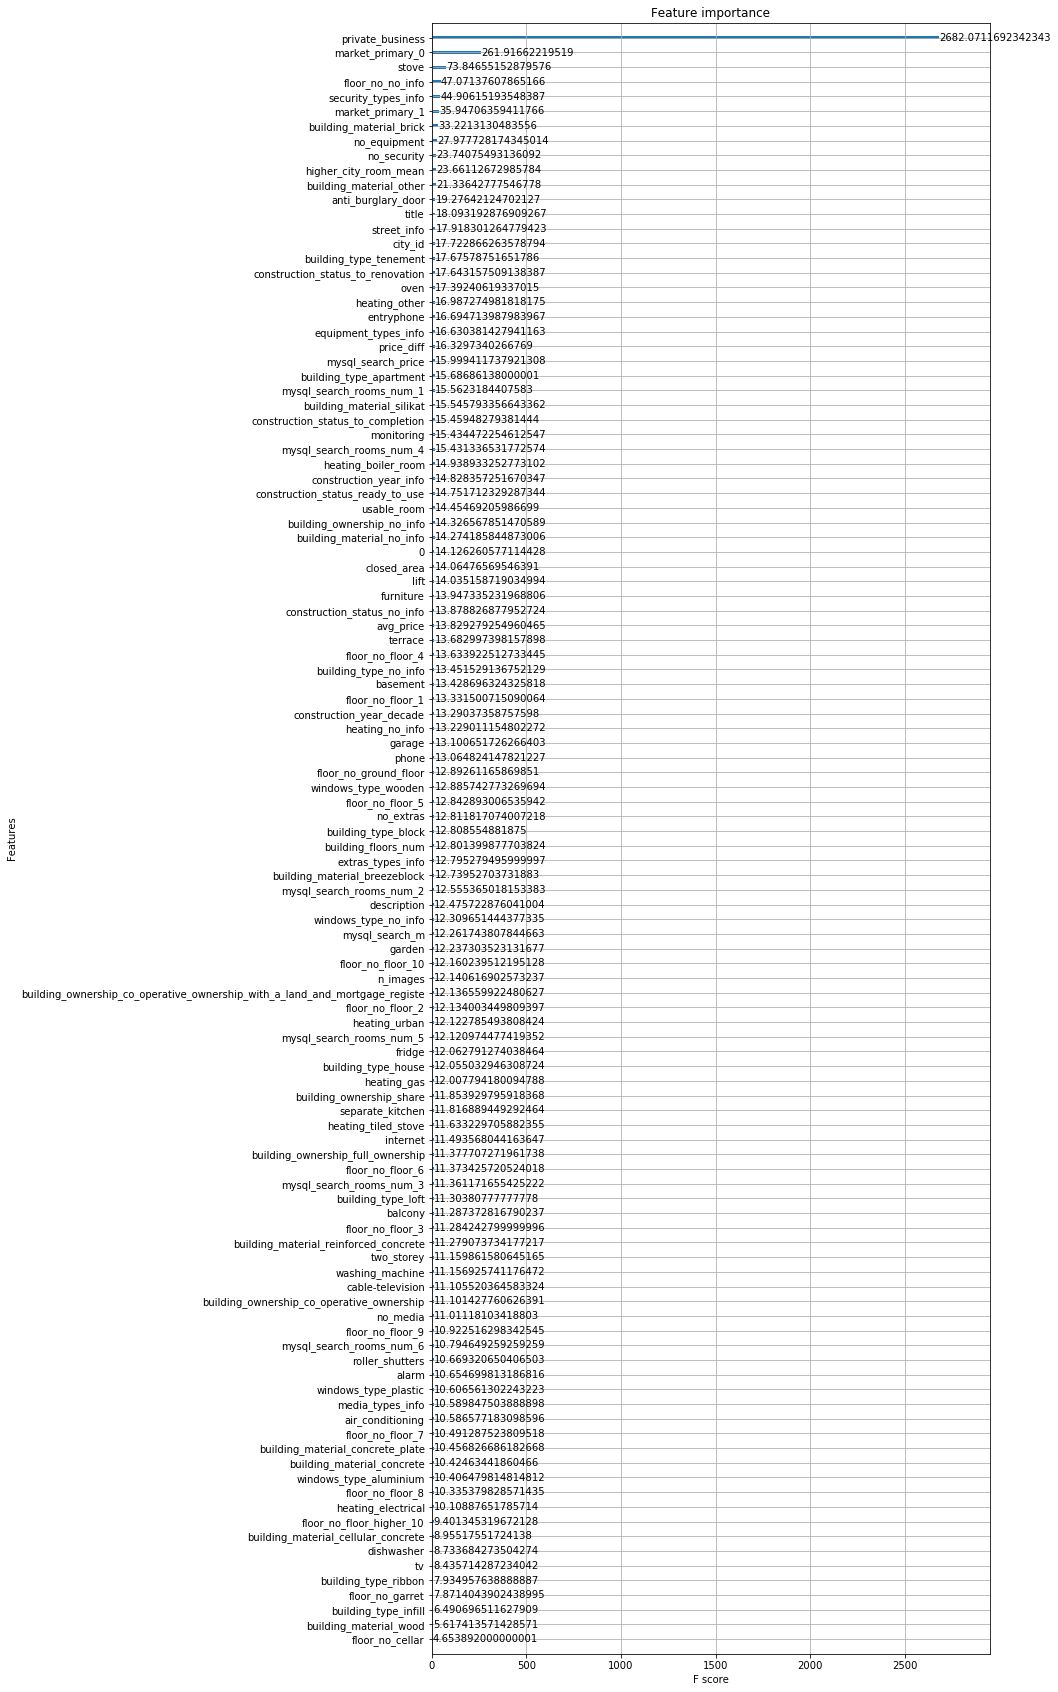

In [47]:
my_plot_importance(clf, figsize=(10, 30),  importance_type='gain' )

**Validation on train:**

In [48]:
y_train_predict = clf.predict(X_train)

In [49]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_train, y_train_predict)))
print('Precision: {0:.2f}'.format(precision_score(y_train,  y_train_predict)))
print('Recall: {0:.2f}'.format(recall_score(y_train,  y_train_predict)))
print('F1: {0:.2f}'.format(f1_score(y_train,  y_train_predict)))

Accuracy: 0.94
Precision: 0.66
Recall: 0.97
F1: 0.79


In [50]:
pd.crosstab(
    pd.Series(y_train, name='Actual'),
    pd.Series(y_train_predict, name='Predicted'),
    margins=True
)

Predicted,0.0,1.0,All
Actual,,,
0.0,178489,38537,217026
1.0,29323,6301,35624
All,207812,44838,252650


In [51]:
print(classification_report(y_train, y_train_predict))

             precision    recall  f1-score   support

          0       1.00      0.93      0.96    296605
          1       0.66      0.97      0.79     40567

avg / total       0.96      0.94      0.94    337172



**Validation on test:**

In [52]:
y_val_predict = clf.predict(X_test)

In [53]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_val_predict)))
print('Precision: {0:.2f}'.format(precision_score(y_test, y_val_predict)))
print('Recall: {0:.2f}'.format(recall_score(y_test, y_val_predict)))
print('F1: {0:.2f}'.format(f1_score(y_test, y_val_predict)))

Accuracy: 0.87
Precision: 0.48
Recall: 0.66
F1: 0.55


In [54]:
pd.crosstab(
    pd.Series(y_test, name='Actual'),
    pd.Series(y_val_predict, name='Predicted'),
    margins=True
)

Predicted,0.0,1.0,All
Actual,,,
0.0,18177,3717,21894
1.0,5206,1058,6264
All,23383,4775,28158


In [55]:
print(classification_report(y_test, y_val_predict))

             precision    recall  f1-score   support

          0       0.95      0.90      0.92     98738
          1       0.48      0.66      0.55     13653

avg / total       0.89      0.87      0.88    112391



**Validation on December data:**

In [56]:
for col in X.columns:
    if col not in X_cv.columns:
        print(col)
        X_cv[col] = 0

pool
attic
building_type_detached
building_type_residence
building_type_semi_detached
windows_type_notany


In [57]:
for col in X_cv.columns:
    if col not in X.columns:
        print(col)
        X_cv = X_cv.drop(col, axis=1)

In [58]:
selected_columns = X.columns 

In [59]:
y_cv_predict = clf.predict(X_cv[selected_columns])

In [60]:
print('Accuracy: {0:.2f}'.format(accuracy_score(y_cv,  y_cv_predict)))
print('Precision: {0:.2f}'.format(precision_score(y_cv,  y_cv_predict)))
print('Recall: {0:.2f}'.format(recall_score(y_cv,  y_cv_predict)))
print('F1: {0:.2f}'.format(f1_score(y_cv,  y_cv_predict)))

Accuracy: 0.87
Precision: 0.47
Recall: 0.61
F1: 0.54


In [61]:
pd.crosstab(
    pd.Series(y_cv, name='Actual'),
    pd.Series(y_cv_predict, name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
0,42442,4272,46714
1,2433,3858,6291
All,44875,8130,53005


In [62]:
print(classification_report(y_cv, y_cv_predict))

             precision    recall  f1-score   support

          0       0.95      0.91      0.93     46714
          1       0.47      0.61      0.54      6291

avg / total       0.89      0.87      0.88     53005



In [63]:
from eli5 import show_weights
show_weights(clf)

Weight,Feature
0.5922,private_business
0.0578,market_primary_0
0.0163,stove
0.0104,floor_no_no_info
0.0099,security_types_info
0.0079,market_primary_1
0.0073,building_material_brick
0.0062,no_equipment
0.0052,no_security
0.0052,higher_city_room_mean


For usage model as a service we need to store:

* average price for city_id/rooms_num combination
* model columns 
* model

**Average price for city_id/rooms_num combination**

In [64]:
avg_city = otodom_full.pipe(select_category, category_id = 101)\
.pipe(filter_currency, currency = 'PLN')\
.pipe(select_columns, columns=columns)\
.pipe(remove_outliers, col='mysql_search_m', lower_bound=20, upper_bound=200)\
.pipe(filter_values, col='mysql_search_rooms_num', values_list=['0', '1', '2', '3', '4', '5', '6'])\
.pipe(remove_outliers, col='mysql_search_price', lower_bound=100000, upper_bound=750000)\
.pipe(count_avg_price_city_ap_type)


In [65]:
avg_city.to_csv("avg_city_price_otodom_buy_02.csv", index=None)

In [66]:
df_avg_city_prices = pd.read_csv("avg_city_price_otodom_buy_02.csv")

In [67]:
df_avg_city_prices.head()

,city_id,mysql_search_rooms_num,avg_price
0,1,1,225905
1,1,2,291305
2,1,3,373476
3,1,4,448689
4,1,5,474952


**Save model columns**

In [68]:
model_columns = list(X_train.columns)
joblib.dump(model_columns, 'model_columns_xgb_otodom_buy_02.pkl')

['model_columns_xgb_otodom_buy_02.pkl']

### Example how it works as a service ###

In [69]:
data = {"city_id": 180, 
        "mysql_search_rooms_num": 2,
        "mysql_search_m": 51.0, 
        "mysql_search_price": 99000,
        "title": 47,
        "description": 978,
        "building_floors_num": 2, 
        "building_material": "brick",
        "equipment_types": "balcony<->separate_kitchen",
        "windows_types": "plastic",
        "private_business": "private",
        "market": "secondary",
        "street_name" : "Chorzovska"
}

In [70]:
test_record = otodom_test_full[otodom_test_full['ad_id'] == 51413220]

In [71]:
df_avg_city_prices.mysql_search_rooms_num = df_avg_city_prices.mysql_search_rooms_num.astype('int')
test_record.mysql_search_rooms_num = test_record.mysql_search_rooms_num.astype('int')

In [72]:
test_record[['city_id', 'mysql_search_rooms_num']]

,city_id,mysql_search_rooms_num
219814,180,2


In [73]:
df_avg_city_prices[df_avg_city_prices['city_id'] == 180]

,city_id,mysql_search_rooms_num,avg_price
315,180,1,115375
316,180,2,141827
317,180,3,198399
318,180,4,197529
319,180,5,425000


In [74]:
test_record[['city_id', 'mysql_search_rooms_num']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 219814 to 219814
Data columns (total 2 columns):
city_id                   1 non-null int64
mysql_search_rooms_num    1 non-null int64
dtypes: int64(2)
memory usage: 24.0 bytes


In [75]:
for c in columns:
    print(test_record[c])

219814    51413220
Name: ad_id, dtype: int64
219814    180
Name: city_id, dtype: int64
219814    Chorzowska
Name: street_name, dtype: object
219814    47
Name: title, dtype: int64
219814    978
Name: description, dtype: int64
219814    2
Name: mysql_search_rooms_num, dtype: int64
219814    51.0
Name: mysql_search_m, dtype: float64
219814    99000
Name: mysql_search_price, dtype: int64
219814   NaN
Name: build_year, dtype: float64
219814    2.0
Name: building_floors_num, dtype: float64
219814    brick
Name: building_material, dtype: object
219814    full_ownership
Name: building_ownership, dtype: object
219814    block
Name: building_type, dtype: object
219814    NaN
Name: construction_status, dtype: object
219814    NaN
Name: equipment_types, dtype: object
219814    balcony<->separate_kitchen
Name: extras_types, dtype: object
219814    NaN
Name: floor_no, dtype: object
219814    NaN
Name: heating, dtype: object
219814    business
Name: private_business, dtype: object
219814    secondar

In [76]:
df_avg_city_prices[['city_id', 'mysql_search_rooms_num']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476 entries, 0 to 4475
Data columns (total 2 columns):
city_id                   4476 non-null int64
mysql_search_rooms_num    4476 non-null int64
dtypes: int64(2)
memory usage: 70.0 KB


In [77]:
df_aggregated = pd.merge(test_record, df_avg_city_prices, on=['city_id', 'mysql_search_rooms_num'])

In [78]:
df_aggregated = df_aggregated.pipe(add_higher_city_room_avg)\
            .pipe(private_business_binarization)\
            .pipe(column_info, col='build_year', new_column_name='construction_year_info')\
            .pipe(create_construction_decade)\
            .pipe(column_info, col='street_name', new_column_name='street_info', drop=True)\
            .pipe(media_types_processing)\
            .pipe(equipment_types_processing)\
            .pipe(security_types_processing)\
            .pipe(extras_types_processing)\
            .pipe(column_info, col='extras_types', new_column_name='extras_types_info', drop=True)\
            .pipe(column_info, col='media_types', new_column_name='media_types_info', drop=True)\
            .pipe(column_info, col='security_types', new_column_name='security_types_info', drop=True)\
            .pipe(column_info, col='equipment_types', new_column_name='equipment_types_info', drop=True)\
            .pipe(column_info, col='heating', new_column_name='heating_info', drop=False)\
            .pipe(market_primary_binarization)\
            .pipe(create_avg_price_diff, avg_price_col='avg_price', price_col='mysql_search_price', new_column_name= 'price_diff')

no_media
no_equipment
no_security
balcony
separate_kitchen


In [79]:
df_aggregated

,Unnamed: 0,ad_id,region_id,category_id,subregion_id,district_id,city_id,user_id,last_update_date,created_at_first,...,no_security,balcony,separate_kitchen,extras_types_info,media_types_info,security_types_info,equipment_types_info,heating_info,market_primary,price_diff
0,219814,51413220,12,101,313,9290.0,180,1709716,NaN,2017-12-02 10:35:10.000000,...,1,1,1,1,0,0,0,0,0,-0.301966


In [80]:
df_aggregated[cat_columns] = df_aggregated[cat_columns].fillna('no_info').astype('str')

In [81]:
df_aggregated[num_columns] = df_aggregated[num_columns].fillna(0)

In [82]:
for col in X.columns:
    if col not in df_aggregated.columns:
        print(col)
        df_aggregated[col] = 0

cable-television
internet
phone
0
electricity
gas
sewage
water
cable_television
furniture
dishwasher
fridge
oven
stove
washing_machine
tv
entryphone
monitoring
anti_burglary_door
closed_area
roller_shutters
alarm
no_extras
garage
lift
basement
usable_room
terrace
garden
air_conditioning
two_storey
pool
attic
mysql_search_rooms_num_1
mysql_search_rooms_num_2
mysql_search_rooms_num_3
mysql_search_rooms_num_4
mysql_search_rooms_num_5
mysql_search_rooms_num_6
building_material_breezeblock
building_material_brick
building_material_cellular_concrete
building_material_concrete
building_material_concrete_plate
building_material_hydroton
building_material_no_info
building_material_other
building_material_reinforced_concrete
building_material_silikat
building_material_wood
building_ownership_co_operative_ownership
building_ownership_co_operative_ownership_with_a_land_and_mortgage_registe
building_ownership_full_ownership
building_ownership_no_info
building_ownership_share
building_type_apartment

In [83]:
for col in df_aggregated.columns:
    if col not in X.columns:
        print(col)
        df_aggregated = df_aggregated.drop(col, axis=1)

Unnamed: 0
ad_id
region_id
category_id
subregion_id
district_id
user_id
last_update_date
created_at_first
valid_to
status
params
map_address
images_counter
paidads_id_index
paidads_id_payment
paidads_valid_to
was_paid_for_post
is_paid_for_post
export_olx_to
brand_program_id
user_quality_score
updated_at
street_id
panorama
mysql_search_rooms_num
mysql_search_price_per_m
movie
ad_quality_score
user_quality_score2
map_lon
map_lat
net_ad_counted
created_at_dt
month
access_types
area_from
area_to
begin_date
building_material
building_ownership
building_type
construction_status
deposit[currency]
dimensions
fence
fence_types
finish_date
floor_no
flooring
floors_num
free_from
garret_type
heating
heating_types
height
is_bungalow
lighting
localization
location
m
non_smokers_only
offered_estates_type
office_space
parking
price
price[currency]
price_from
price_per_m
price_per_m_from
price_to
ramp
recreational
rent[currency]
rent_to_students
roof_type
roofing
rooms_num
roomsize
social_facilities
st

In [84]:
df_aggregated

,city_id,title,description,private_business,mysql_search_m,mysql_search_price,building_floors_num,n_images,avg_price,higher_city_room_mean,...,heating_other,heating_tiled_stove,heating_urban,windows_type_aluminium,windows_type_no_info,windows_type_notany,windows_type_plastic,windows_type_wooden,market_primary_0,market_primary_1
0,180,47,978,0,51.0,99000,2.0,13,141827,0,...,0,0,0,0,0,0,0,0,0,0


In [85]:
selected_columns = X_train.columns

In [86]:
df_aggregated = df_aggregated[selected_columns]

In [87]:
clf.predict_proba(df_aggregated)

array([[0.662295, 0.337705]], dtype=float32)

In [88]:
from eli5 import show_prediction
show_prediction(clf, df_aggregated.iloc[0], show_feature_values=True, top=20)

In [89]:
model_columns = [
           'city_id', 
           'street_name', 
           'title', 
           'description', 
           'was_paid_for_post',  
           'is_paid_for_post', 
           'mysql_search_rooms_num', 
           'mysql_search_m', 
           'mysql_search_price', 
           'build_year', 
           'building_floors_num',  
           'building_material', 
           'building_ownership', 
           'building_type',
           'construction_status', 
           'equipment_types', 
           'extras_types', 
           'floor_no', 
           'heating', 
           'private_business', 
           'market', 
           'media_types',  
           'security_types', 
           'windows_type',
           'n_images']

In [90]:
avg_city.head()

,city_id,mysql_search_rooms_num,avg_price
0,1,1,225905
1,1,2,291305
2,1,3,373476
3,1,4,448689
4,1,5,474952


In [91]:
avg_city.mysql_search_rooms_num = avg_city.mysql_search_rooms_num.astype('int')

In [92]:
avg_city.head()

,city_id,mysql_search_rooms_num,avg_price
0,1,1,225905
1,1,2,291305
2,1,3,373476
3,1,4,448689
4,1,5,474952


In [93]:
data = {
        "city_id": 1,
        "title": 30,
        "description": 1000,
        "private_business": "private",
        "street_name" : "Vodickova",
        "mysql_search_rooms_num": 2,
        "mysql_search_m": 80,
        "mysql_search_price": 200000,
        "build_year": 2011,
    }

In [94]:
def get_dataframe(json):
    df = pd.DataFrame.from_dict([dict(json)])
    return df

In [95]:
t1 = get_dataframe(data)

In [96]:
t1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 9 columns):
build_year                1 non-null int64
city_id                   1 non-null int64
description               1 non-null int64
mysql_search_m            1 non-null int64
mysql_search_price        1 non-null int64
mysql_search_rooms_num    1 non-null int64
private_business          1 non-null object
street_name               1 non-null object
title                     1 non-null int64
dtypes: int64(7), object(2)
memory usage: 152.0+ bytes


avg_city should be stored as csv
price/area quantiles?????

In [97]:
avg_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476 entries, 0 to 4475
Data columns (total 3 columns):
city_id                   4476 non-null int64
mysql_search_rooms_num    4476 non-null int64
avg_price                 4476 non-null int64
dtypes: int64(3)
memory usage: 105.0 KB


In [98]:
t1 = t1.merge(avg_city, on= ['city_id', 'mysql_search_rooms_num'])

In [99]:
t1.head()

,build_year,city_id,description,mysql_search_m,mysql_search_price,mysql_search_rooms_num,private_business,street_name,title,avg_price
0,2011,1,1000,80,200000,2,private,Vodickova,30,291305


In [100]:
t1.head()

,build_year,city_id,description,mysql_search_m,mysql_search_price,mysql_search_rooms_num,private_business,street_name,title,avg_price
0,2011,1,1000,80,200000,2,private,Vodickova,30,291305


In [101]:
for col in model_columns:
    if col not in t1.columns:
        print(col)
        t1[col] = None

was_paid_for_post
is_paid_for_post
building_floors_num
building_material
building_ownership
building_type
construction_status
equipment_types
extras_types
floor_no
heating
market
media_types
security_types
windows_type
n_images


In [102]:
f2 = t1\
.pipe(add_higher_city_room_avg)\
.pipe(private_business_binarization)\
.pipe(column_info, col='build_year', new_column_name='construction_year_info')\
.pipe(create_construction_decade)\
.pipe(media_types_processing)\
.pipe(equipment_types_processing)\
.pipe(security_types_processing)\
.pipe(extras_types_processing)\
.pipe(column_info, col='street_name', new_column_name='street_info', drop=True)\
.pipe(column_info, col='extras_types', new_column_name='extras_types_info', drop=True)\
.pipe(column_info, col='media_types', new_column_name='media_types_info', drop=True)\
.pipe(column_info, col='security_types', new_column_name='security_types_info', drop=True)\
.pipe(column_info, col='equipment_types', new_column_name='equipment_types_info', drop=True)\
.pipe(column_info, col='heating', new_column_name='heating_info', drop=False)\
.pipe(market_primary_binarization)\
.pipe(create_avg_price_diff, avg_price_col='avg_price', price_col='mysql_search_price', new_column_name= 'price_diff')

no_media
no_equipment
no_security
no_extras


In [103]:
f2[num_columns] = f2[num_columns].fillna(0)

In [104]:
#f2[num_columns] = scaler.transform(f2[num_columns])

In [105]:
f2[cat_columns] = f2[cat_columns].fillna('no_info')

In [106]:
f2 = pd.get_dummies(f2)

In [107]:
#f2 = f2.fillna(np.nan)

In [108]:
f2.iloc[0,]

city_id                             1.000000
description                      1000.000000
mysql_search_m                     80.000000
mysql_search_price             200000.000000
mysql_search_rooms_num              2.000000
private_business                    1.000000
title                              30.000000
avg_price                      291305.000000
building_floors_num                 0.000000
n_images                            0.000000
higher_city_room_mean               0.000000
construction_year_info              1.000000
construction_year_decade          201.000000
no_media                            1.000000
no_equipment                        1.000000
no_security                         1.000000
no_extras                           1.000000
street_info                         1.000000
extras_types_info                   0.000000
media_types_info                    0.000000
security_types_info                 0.000000
equipment_types_info                0.000000
heating_in

In [109]:
for col in X_train.columns:
    if col not in f2.columns:
        print(col)
        f2[col] = 0

cable-television
internet
phone
0
electricity
gas
sewage
water
cable_television
furniture
dishwasher
fridge
oven
stove
washing_machine
tv
entryphone
monitoring
anti_burglary_door
closed_area
roller_shutters
alarm
balcony
garage
lift
basement
separate_kitchen
usable_room
terrace
garden
air_conditioning
two_storey
pool
attic
mysql_search_rooms_num_1
mysql_search_rooms_num_2
mysql_search_rooms_num_3
mysql_search_rooms_num_4
mysql_search_rooms_num_5
mysql_search_rooms_num_6
building_material_breezeblock
building_material_brick
building_material_cellular_concrete
building_material_concrete
building_material_concrete_plate
building_material_hydroton
building_material_other
building_material_reinforced_concrete
building_material_silikat
building_material_wood
building_ownership_co_operative_ownership
building_ownership_co_operative_ownership_with_a_land_and_mortgage_registe
building_ownership_full_ownership
building_ownership_share
building_type_apartment
building_type_block
building_type_det

In [110]:
sel_cols = X_train.columns

In [111]:
f2 = f2[sel_cols]

In [112]:
f2.columns

Index(['city_id', 'title', 'description', 'mysql_search_m',
       'mysql_search_price', 'building_floors_num', 'private_business',
       'n_images', 'avg_price', 'higher_city_room_mean',
       ...
       'heating_other', 'heating_tiled_stove', 'heating_urban',
       'windows_type_aluminium', 'windows_type_no_info', 'windows_type_notany',
       'windows_type_plastic', 'windows_type_wooden', 'market_primary_0',
       'market_primary_1'],
      dtype='object', length=122)

In [113]:
clf.predict_proba(f2)

array([[0.0284515, 0.9715485]], dtype=float32)

In [114]:
test_f2 = f2.iloc[0]

In [115]:
from eli5 import show_prediction
show_prediction(clf, test_f2, show_feature_values=True, top=20)

In [116]:
# city average - to store
explanation = show_prediction(clf, test_f2, show_feature_values=True)

In [117]:
from eli5 import explain_prediction_df

In [118]:
explain_prediction_df(clf, test_f2, top=10)

,target,feature,weight,value
0,1,private_business,5.597451,1.000000
1,1,price_diff,0.528681,-0.313434
2,1,mysql_search_m,0.392397,80.000000
3,1,<BIAS>,0.306665,1.000000
4,1,city_id,0.261231,1.000000
5,1,description,-0.206989,1000.000000
6,1,construction_year_decade,-0.267938,201.000000
7,1,market_primary_0,-0.400836,0.000000
8,1,title,-0.455625,30.000000
9,1,n_images,-1.132812,0.000000


In [119]:
X_train.columns

Index(['city_id', 'title', 'description', 'mysql_search_m',
       'mysql_search_price', 'building_floors_num', 'private_business',
       'n_images', 'avg_price', 'higher_city_room_mean',
       ...
       'heating_other', 'heating_tiled_stove', 'heating_urban',
       'windows_type_aluminium', 'windows_type_no_info', 'windows_type_notany',
       'windows_type_plastic', 'windows_type_wooden', 'market_primary_0',
       'market_primary_1'],
      dtype='object', length=122)